In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cell 1: Import Libraries and Setup
"""
Movie Genre Prediction using Text Classification
This notebook demonstrates how to predict movie genres based on plot summaries
using various ML techniques including TF-IDF and different classifiers.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('stopwords', quiet=True)

print("Libraries imported successfully!")
print("Ready to start building our movie genre predictor 🎬")

Libraries imported successfully!
Ready to start building our movie genre predictor 🎬


In [ ]:
# Cell 2: Load and Explore the Dataset
"""
Let's load our dataset and split the single column into appropriate columns.
"""

# Load the data, assuming the delimiter is tab and there's no header initially
train_data = pd.read_csv('train_data.txt', sep='\t', header=None)

# Check if the data was loaded into a single column
if train_data.shape[1] == 1:
    print("Data loaded into a single column. Splitting...")
    # Split the single column into multiple columns based on ' ::: '
    # We need to be careful with the number of expected splits
    # Assuming the format is ID ::: TITLE ::: GENRE ::: DESCRIPTION
    train_data[['movie_id', 'title', 'genre', 'description']] = train_data[0].str.split(' ::: ', expand=True)

    # Drop the original single column
    train_data = train_data.drop(columns=[0])

# Now check the column names and shape after splitting
print("Dataset loaded and processed successfully!")
print(f"Shape of training data: {train_data.shape}")
print(f"Column names: {list(train_data.columns)}")
print("\nFirst few rows:")
print(train_data.head())

print("\nDataset Info:")
print(train_data.info())

# Check for missing values
print("\nMissing values per column:")
print(train_data.isnull().sum())

Data loaded into a single column. Splitting...
Dataset loaded and processed successfully!
Shape of training data: (54214, 4)
Column names: ['movie_id', 'title', 'genre', 'description']

First few rows:
  movie_id                             title     genre  \
0        1      Oscar et la dame rose (2009)     drama   
1        2                      Cupid (1997)  thriller   
2        3  Young, Wild and Wonderful (1980)     adult   
3        4             The Secret Sin (1915)     drama   
4        5            The Unrecovered (2007)     drama   

                                         description  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 column

Missing values in each column:
movie_id       0
title          0
genre          0
description    0
dtype: int64

Data shape after removing missing values: (54214, 4)
Removed 0 rows with missing data


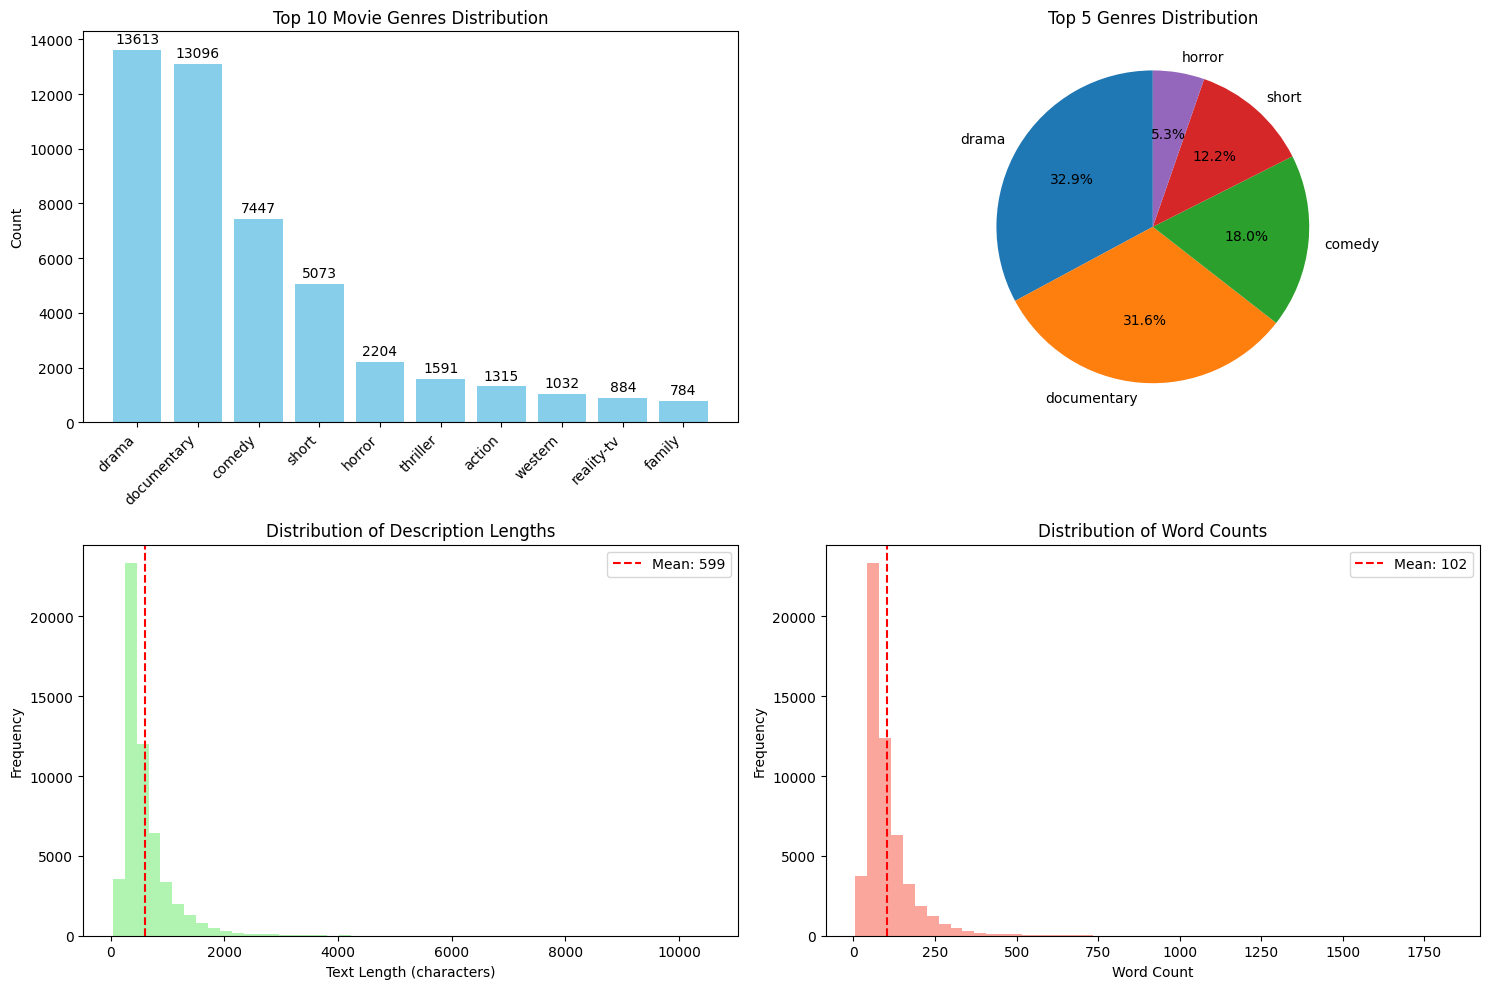


Dataset Summary:
• Total samples: 54,214
• Unique genres: 27
• Average description length: 599 characters
• Average word count: 102 words
• Most common genre: 'drama' (13,613 samples)

Top 15 Genre Distribution:
 1. drama               : 13,613 samples ( 25.1%)
 2. documentary         : 13,096 samples ( 24.2%)
 3. comedy              :  7,447 samples ( 13.7%)
 4. short               :  5,073 samples (  9.4%)
 5. horror              :  2,204 samples (  4.1%)
 6. thriller            :  1,591 samples (  2.9%)
 7. action              :  1,315 samples (  2.4%)
 8. western             :  1,032 samples (  1.9%)
 9. reality-tv          :    884 samples (  1.6%)
10. family              :    784 samples (  1.4%)
11. adventure           :    775 samples (  1.4%)
12. music               :    731 samples (  1.3%)
13. romance             :    672 samples (  1.2%)
14. sci-fi              :    647 samples (  1.2%)
15. adult               :    590 samples (  1.1%)


In [ ]:
# Cell 3: Data Cleaning and Exploration
"""
Let's clean the data and explore the distribution of genres and text characteristics.
"""

# Check for missing values
print("Missing values in each column:")
print(train_data.isnull().sum())

# Remove rows with missing descriptions or genres (our main features)
initial_rows = len(train_data)
train_data = train_data.dropna(subset=['description', 'genre'])
final_rows = len(train_data)

print(f"\nData shape after removing missing values: {train_data.shape}")
print(f"Removed {initial_rows - final_rows} rows with missing data")

if final_rows > 0:
    # Explore genre distribution
    genre_counts = train_data['genre'].value_counts()

    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Top 10 genres bar plot
    top_genres = genre_counts.head(10)
    axes[0, 0].bar(range(len(top_genres)), top_genres.values, color='skyblue')
    axes[0, 0].set_xticks(range(len(top_genres)))
    axes[0, 0].set_xticklabels(top_genres.index, rotation=45, ha='right')
    axes[0, 0].set_title('Top 10 Movie Genres Distribution')
    axes[0, 0].set_ylabel('Count')

    # Add count labels on bars
    for i, v in enumerate(top_genres.values):
        axes[0, 0].text(i, v + max(top_genres.values) * 0.01, str(v),
                       ha='center', va='bottom')

    # Top 5 genres pie chart
    top5_genres = genre_counts.head(5)
    axes[0, 1].pie(top5_genres.values, labels=top5_genres.index,
                   autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Top 5 Genres Distribution')

    # Text length analysis
    train_data['text_length'] = train_data['description'].astype(str).str.len()
    axes[1, 0].hist(train_data['text_length'], bins=50, alpha=0.7, color='lightgreen')
    axes[1, 0].set_xlabel('Text Length (characters)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Description Lengths')
    axes[1, 0].axvline(train_data['text_length'].mean(), color='red', linestyle='--',
                      label=f'Mean: {train_data["text_length"].mean():.0f}')
    axes[1, 0].legend()

    # Word count analysis
    train_data['word_count'] = train_data['description'].astype(str).str.split().str.len()
    axes[1, 1].hist(train_data['word_count'], bins=50, alpha=0.7, color='salmon')
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Word Counts')
    axes[1, 1].axvline(train_data['word_count'].mean(), color='red', linestyle='--',
                      label=f'Mean: {train_data["word_count"].mean():.0f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print(f"\nDataset Summary:")
    print(f"• Total samples: {len(train_data):,}")
    print(f"• Unique genres: {train_data['genre'].nunique()}")
    print(f"• Average description length: {train_data['text_length'].mean():.0f} characters")
    print(f"• Average word count: {train_data['word_count'].mean():.0f} words")
    print(f"• Most common genre: '{genre_counts.index[0]}' ({genre_counts.iloc[0]:,} samples)")

    # Show detailed genre distribution
    print(f"\nTop 15 Genre Distribution:")
    for i, (genre, count) in enumerate(genre_counts.head(15).items()):
        percentage = (count / len(train_data)) * 100
        print(f"{i+1:2d}. {genre:<20}: {count:>6,} samples ({percentage:>5.1f}%)")

else:
    print("❌ No valid data remaining after cleaning!")
    raise ValueError("Please check your data files - no valid samples found.")

Libraries imported successfully!
Ready to start building our movie genre predictor 🎬
Data loaded into a single column. Splitting...
Dataset loaded and processed successfully!
Shape of training data: (54214, 4)
Column names: ['movie_id', 'title', 'genre', 'description']

First few rows:
  movie_id                             title     genre  \
0        1      Oscar et la dame rose (2009)     drama   
1        2                      Cupid (1997)  thriller   
2        3  Young, Wild and Wonderful (1980)     adult   
3        4             The Secret Sin (1915)     drama   
4        5            The Unrecovered (2007)     drama   

                                         description  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  

Dataset Info:
<class 'pandas.core

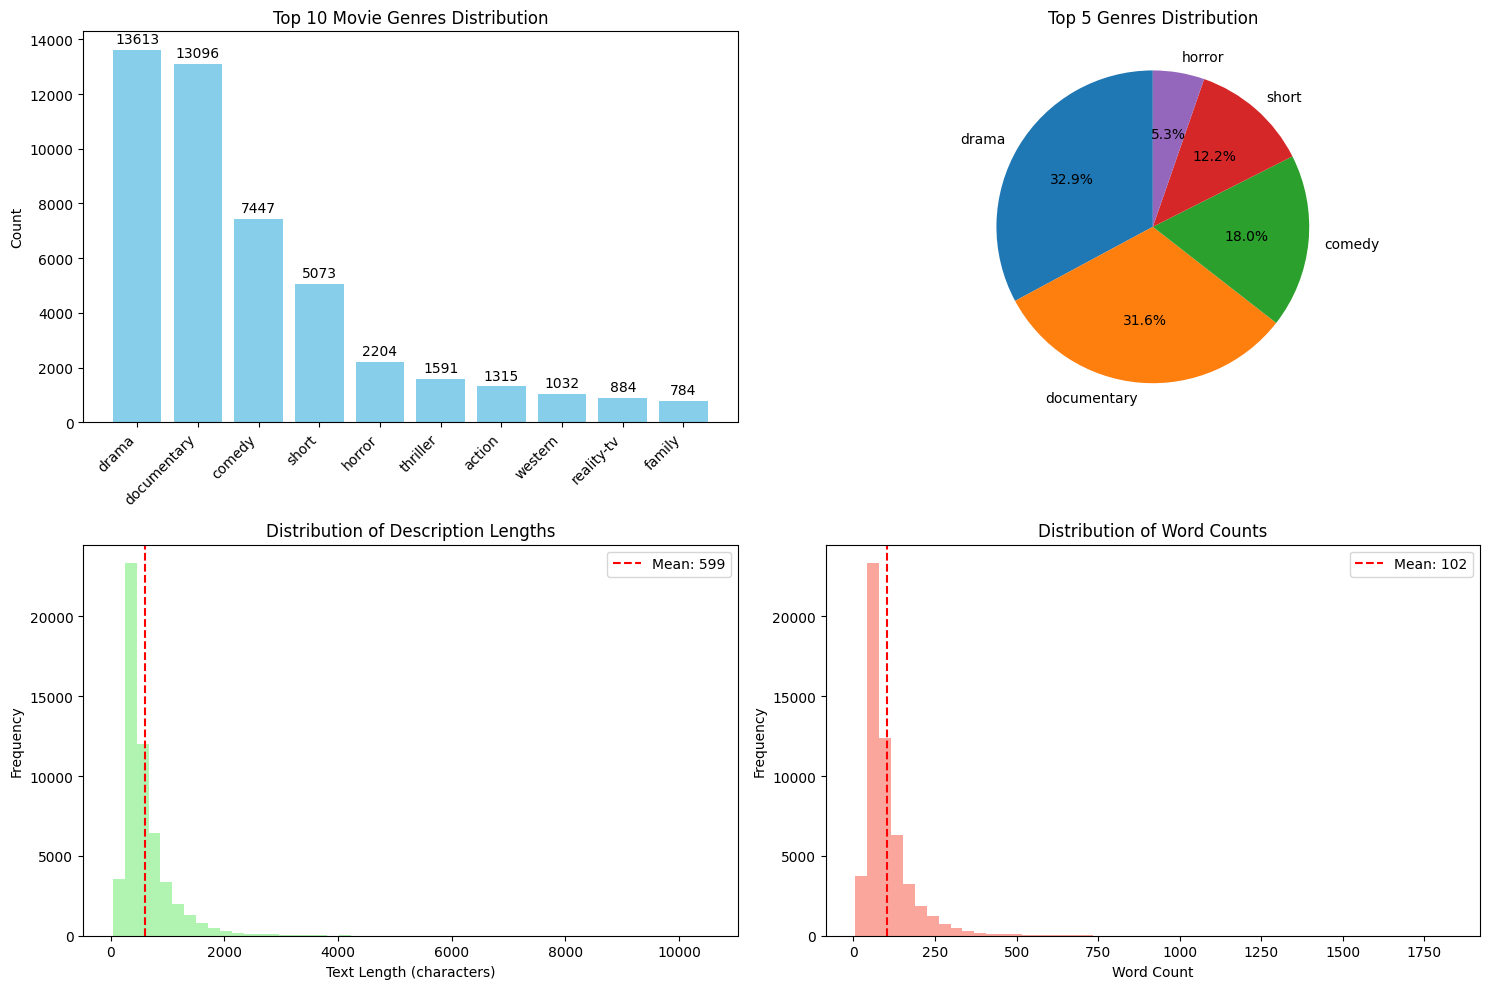


Dataset Summary:
• Total samples: 54,214
• Unique genres: 27
• Average description length: 599 characters
• Average word count: 102 words
• Most common genre: 'drama' (13,613 samples)

Top 15 Genre Distribution:
 1. drama               : 13,613 samples ( 25.1%)
 2. documentary         : 13,096 samples ( 24.2%)
 3. comedy              :  7,447 samples ( 13.7%)
 4. short               :  5,073 samples (  9.4%)
 5. horror              :  2,204 samples (  4.1%)
 6. thriller            :  1,591 samples (  2.9%)
 7. action              :  1,315 samples (  2.4%)
 8. western             :  1,032 samples (  1.9%)
 9. reality-tv          :    884 samples (  1.6%)
10. family              :    784 samples (  1.4%)
11. adventure           :    775 samples (  1.4%)
12. music               :    731 samples (  1.3%)
13. romance             :    672 samples (  1.2%)
14. sci-fi              :    647 samples (  1.2%)
15. adult               :    590 samples (  1.1%)
Sample text preprocessing:
Original (

In [ ]:
# Cell 1: Import Libraries and Setup
"""
Movie Genre Prediction using Text Classification
This notebook demonstrates how to predict movie genres based on plot summaries
using various ML techniques including TF-IDF and different classifiers.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('stopwords', quiet=True)

print("Libraries imported successfully!")
print("Ready to start building our movie genre predictor 🎬")

# Cell 2: Load and Explore the Dataset
"""
Let's load our dataset and split the single column into appropriate columns.
"""

# Load the data, assuming the delimiter is tab and there's no header initially
train_data = pd.read_csv('train_data.txt', sep='\t', header=None)

# Check if the data was loaded into a single column
if train_data.shape[1] == 1:
    print("Data loaded into a single column. Splitting...")
    # Split the single column into multiple columns based on ' ::: '
    # We need to be careful with the number of expected splits
    # Assuming the format is ID ::: TITLE ::: GENRE ::: DESCRIPTION
    train_data[['movie_id', 'title', 'genre', 'description']] = train_data[0].str.split(' ::: ', expand=True)

    # Drop the original single column
    train_data = train_data.drop(columns=[0])

# Now check the column names and shape after splitting
print("Dataset loaded and processed successfully!")
print(f"Shape of training data: {train_data.shape}")
print(f"Column names: {list(train_data.columns)}")
print("\nFirst few rows:")
print(train_data.head())

print("\nDataset Info:")
print(train_data.info())

# Cell 3: Data Cleaning and Exploration
"""
Let's clean the data and explore the distribution of genres and text characteristics.
"""

# Check for missing values
print("Missing values in each column:")
print(train_data.isnull().sum())

# Remove rows with missing descriptions or genres (our main features)
initial_rows = len(train_data)
train_data = train_data.dropna(subset=['description', 'genre'])
final_rows = len(train_data)

print(f"\nData shape after removing missing values: {train_data.shape}")
print(f"Removed {initial_rows - final_rows} rows with missing data")

if final_rows > 0:
    # Explore genre distribution
    genre_counts = train_data['genre'].value_counts()

    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Top 10 genres bar plot
    top_genres = genre_counts.head(10)
    axes[0, 0].bar(range(len(top_genres)), top_genres.values, color='skyblue')
    axes[0, 0].set_xticks(range(len(top_genres)))
    axes[0, 0].set_xticklabels(top_genres.index, rotation=45, ha='right')
    axes[0, 0].set_title('Top 10 Movie Genres Distribution')
    axes[0, 0].set_ylabel('Count')

    # Add count labels on bars
    for i, v in enumerate(top_genres.values):
        axes[0, 0].text(i, v + max(top_genres.values) * 0.01, str(v),
                       ha='center', va='bottom')

    # Top 5 genres pie chart
    top5_genres = genre_counts.head(5)
    axes[0, 1].pie(top5_genres.values, labels=top5_genres.index,
                   autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Top 5 Genres Distribution')

    # Text length analysis
    train_data['text_length'] = train_data['description'].astype(str).str.len()
    axes[1, 0].hist(train_data['text_length'], bins=50, alpha=0.7, color='lightgreen')
    axes[1, 0].set_xlabel('Text Length (characters)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Description Lengths')
    axes[1, 0].axvline(train_data['text_length'].mean(), color='red', linestyle='--',
                      label=f'Mean: {train_data["text_length"].mean():.0f}')
    axes[1, 0].legend()

    # Word count analysis
    train_data['word_count'] = train_data['description'].astype(str).str.split().str.len()
    axes[1, 1].hist(train_data['word_count'], bins=50, alpha=0.7, color='salmon')
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Word Counts')
    axes[1, 1].axvline(train_data['word_count'].mean(), color='red', linestyle='--',
                      label=f'Mean: {train_data["word_count"].mean():.0f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print(f"\nDataset Summary:")
    print(f"• Total samples: {len(train_data):,}")
    print(f"• Unique genres: {train_data['genre'].nunique()}")
    print(f"• Average description length: {train_data['text_length'].mean():.0f} characters")
    print(f"• Average word count: {train_data['word_count'].mean():.0f} words")
    print(f"• Most common genre: '{genre_counts.index[0]}' ({genre_counts.iloc[0]:,} samples)")

    # Show detailed genre distribution
    print(f"\nTop 15 Genre Distribution:")
    for i, (genre, count) in enumerate(genre_counts.head(15).items()):
        percentage = (count / len(train_data)) * 100
        print(f"{i+1:2d}. {genre:<20}: {count:>6,} samples ({percentage:>5.1f}%)")

else:
    print("❌ No valid data remaining after cleaning!")
    raise ValueError("Please check your data files - no valid samples found.")

# Cell 4: Text Preprocessing Functions
"""
Text preprocessing is crucial for getting good results from our models.
We'll clean the text by removing noise and standardizing the format.
"""

# Initialize stemmer and get stopwords
stemmer = PorterStemmer()
try:
    stop_words = set(stopwords.words('english'))
except:
    # If NLTK data isn't downloaded, use a basic set
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}

def clean_text_basic(text):
    """
    Basic text cleaning function
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove special characters and numbers, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

def clean_text_advanced(text, remove_stopwords=True, apply_stemming=False):
    """
    Advanced text preprocessing with optional stopword removal and stemming
    """
    # Start with basic cleaning
    text = clean_text_basic(text)

    if not text:
        return ""

    # Split into words
    words = text.split()

    # Remove stopwords if requested
    if remove_stopwords:
        words = [word for word in words if word not in stop_words and len(word) > 2]

    # Apply stemming if requested
    if apply_stemming:
        words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Test preprocessing functions with sample data
if len(train_data) > 0:
    sample_text = train_data['description'].iloc[0]
    print("Sample text preprocessing:")
    print("=" * 60)
    print(f"Original ({len(str(sample_text))} chars):")
    print(f"{str(sample_text)[:200]}...")
    print(f"\nBasic cleaning ({len(clean_text_basic(sample_text))} chars):")
    print(f"{clean_text_basic(sample_text)[:200]}...")
    print(f"\nAdvanced cleaning ({len(clean_text_advanced(sample_text))} chars):")
    print(f"{clean_text_advanced(sample_text)[:200]}...")

Applying text preprocessing to all descriptions...
This may take a moment for large datasets...
Removed 0 samples with empty descriptions after preprocessing
Final dataset size: 54,214 samples


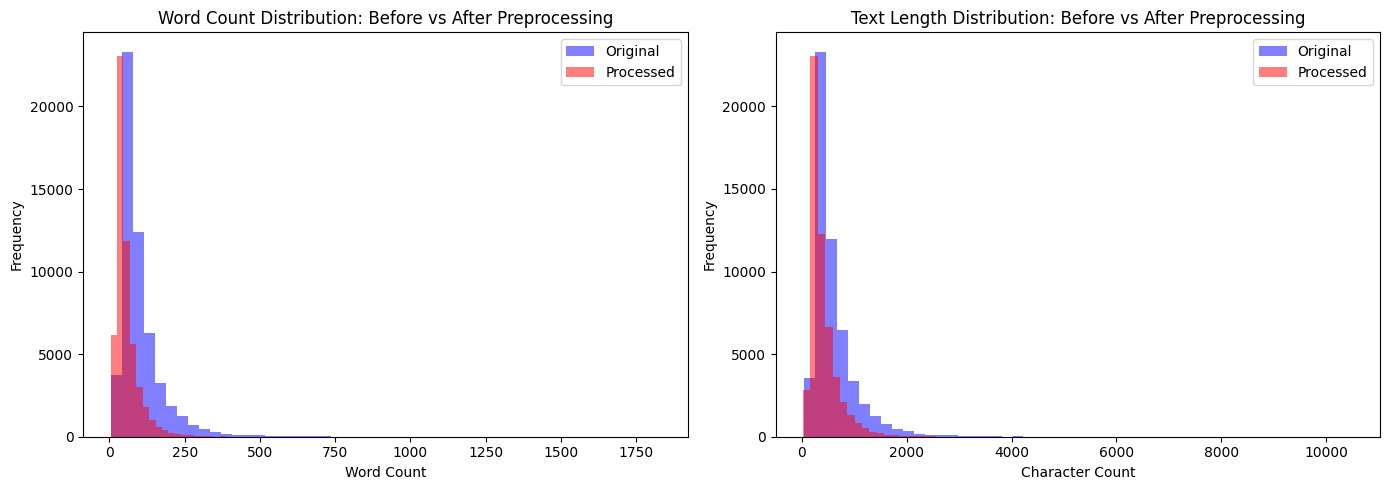

Preprocessing Results:
• Average original word count: 101.9
• Average processed word count: 56.6
• Word count reduction: 44.5%
Preparing features for 54,214 samples with 27 different genres
Training set: 43,371 samples
Test set: 10,843 samples
Creating TF-IDF features...
This process extracts important words and phrases from the text...
TF-IDF matrix shape: (43371, 15000)
Feature vector dimensions: 15,000 features
Sparsity: 99.72%

Sample TF-IDF features:
First 20: ['aaron', 'aarti', 'abandon', 'abandoned', 'abandoned house', 'abandoning', 'abandonment', 'abandons', 'abby', 'abc', 'abduct', 'abducted', 'abduction', 'abducts', 'abdul', 'abel', 'abigail', 'abilities', 'ability', 'able']
Random sample: ['use', 'comes rescue', 'percent', 'documentary following', 'juxtaposed', 'air force', 'leopold', 'panics', 'scope', 'fishing village']


In [ ]:
# Cell 5: Apply Text Preprocessing to Dataset
"""
Now let's apply our preprocessing to the entire dataset and prepare features.
"""

print("Applying text preprocessing to all descriptions...")
print("This may take a moment for large datasets...")

# Apply different levels of preprocessing
train_data['description_clean'] = train_data['description'].apply(clean_text_basic)
train_data['description_processed'] = train_data['description'].apply(
    lambda x: clean_text_advanced(x, remove_stopwords=True, apply_stemming=False)
)

# Remove empty descriptions after preprocessing
initial_count = len(train_data)
train_data = train_data[train_data['description_processed'].str.len() > 0]
final_count = len(train_data)

print(f"Removed {initial_count - final_count} samples with empty descriptions after preprocessing")
print(f"Final dataset size: {final_count:,} samples")

# Update text statistics after preprocessing
train_data['processed_length'] = train_data['description_processed'].str.len()
train_data['processed_word_count'] = train_data['description_processed'].str.split().str.len()

# Visualization of preprocessing effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before and after word count comparison
axes[0].hist(train_data['word_count'], bins=50, alpha=0.5, label='Original', color='blue')
axes[0].hist(train_data['processed_word_count'], bins=50, alpha=0.5, label='Processed', color='red')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Word Count Distribution: Before vs After Preprocessing')
axes[0].legend()

# Text length comparison
axes[1].hist(train_data['text_length'], bins=50, alpha=0.5, label='Original', color='blue')
axes[1].hist(train_data['processed_length'], bins=50, alpha=0.5, label='Processed', color='red')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Text Length Distribution: Before vs After Preprocessing')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Preprocessing Results:")
print(f"• Average original word count: {train_data['word_count'].mean():.1f}")
print(f"• Average processed word count: {train_data['processed_word_count'].mean():.1f}")
print(f"• Word count reduction: {((train_data['word_count'].mean() - train_data['processed_word_count'].mean()) / train_data['word_count'].mean() * 100):.1f}%")

# Cell 6: Feature Engineering with TF-IDF
"""
TF-IDF (Term Frequency-Inverse Document Frequency) converts text to numerical features
that capture the importance of words in each document relative to the entire corpus.
"""

# Prepare features and target
X = train_data['description_processed']
y = train_data['genre']

print(f"Preparing features for {len(X):,} samples with {y.nunique()} different genres")

# Split the data before any feature extraction to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Create TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,      # Keep top 15k features
    ngram_range=(1, 2),      # Use both unigrams and bigrams
    min_df=3,               # Ignore terms appearing in less than 3 documents
    max_df=0.85,            # Ignore terms appearing in more than 85% of documents
    stop_words='english',    # Remove English stop words
    lowercase=True,         # Convert to lowercase (though we already did this)
    strip_accents='ascii'   # Remove accents
)

print("Creating TF-IDF features...")
print("This process extracts important words and phrases from the text...")

# Fit on training data only to prevent data leakage
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Feature vector dimensions: {X_train_tfidf.shape[1]:,} features")
print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

# Show sample of extracted features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample TF-IDF features:")
print(f"First 20: {list(feature_names[:20])}")
print(f"Random sample: {list(np.random.choice(feature_names, 10))}")

Preparing features for 54,214 samples with 27 different genres 📊
Training set: 43,371 samples 💪
Test set: 10,843 samples ✅
Creating TF-IDF features... 📝
This process extracts important words and phrases from the text... ✨
TF-IDF matrix shape: (43371, 15000)
Feature vector dimensions: 15,000 features
Sparsity: 99.72%

Sample TF-IDF features:
First 20: ['aaron', 'aarti', 'abandon', 'abandoned', 'abandoned house', 'abandoning', 'abandonment', 'abandons', 'abby', 'abc', 'abduct', 'abducted', 'abduction', 'abducts', 'abdul', 'abel', 'abigail', 'abilities', 'ability', 'able']
Random sample: ['mother children', 'lsd', 'isaac', 'naturally', 'sylvia', 'institute', 'gays', 'low level', 'supervision', 'puzzled']

Training Multinomial Naive Bayes classifier... 🧪
Naive Bayes Accuracy: 0.5603
              precision    recall  f1-score   support

      action       0.52      0.24      0.32       263
       adult       0.54      0.19      0.28       118
   adventure       0.56      0.12      0.19    

ValueError: 'yerr' (shape: (4,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (3,))

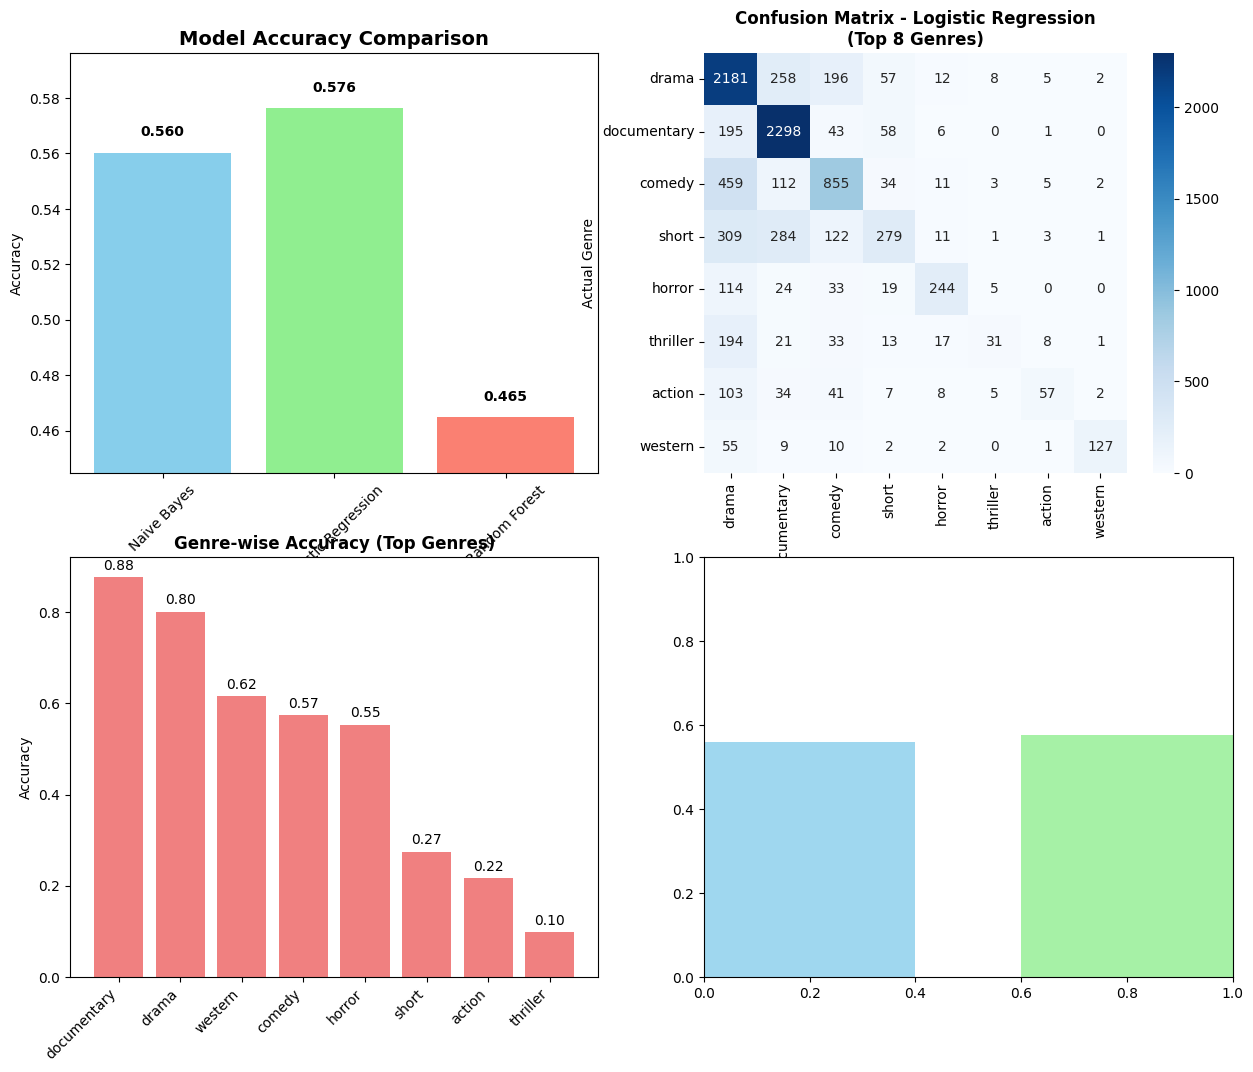

In [9]:
# Cell 6: Feature Engineering with TF-IDF (Included for fixing NameError)
"""
TF-IDF (Term Frequency-Inverse Document Frequency) converts text to numerical features
that capture the importance of words in each document relative to the entire corpus.
"""

# Prepare features and target
X = train_data['description_processed']
y = train_data['genre']

print(f"Preparing features for {len(X):,} samples with {y.nunique()} different genres 📊")

# Split the data before any feature extraction to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples 💪")
print(f"Test set: {len(X_test):,} samples ✅")

# Create TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,      # Keep top 15k features
    ngram_range=(1, 2),      # Use both unigrams and bigrams
    min_df=3,               # Ignore terms appearing in less than 3 documents
    max_df=0.85,            # Ignore terms appearing in more than 85% of documents
    stop_words='english',    # Remove English stop words
    lowercase=True,         # Convert to lowercase (though we already did this)
    strip_accents='ascii'   # Remove accents
)

print("Creating TF-IDF features... 📝")
print("This process extracts important words and phrases from the text... ✨")

# Fit on training data only to prevent data leakage
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Feature vector dimensions: {X_train_tfidf.shape[1]:,} features")
print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

# Show sample of extracted features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample TF-IDF features:")
print(f"First 20: {list(feature_names[:20])}")
print(f"Random sample: {list(np.random.choice(feature_names, 10))}")


# Cell 7: Model Training - Naive Bayes Classifier
print("\nTraining Multinomial Naive Bayes classifier... 🧪")
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
nb_predictions = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(classification_report(y_test, nb_predictions, target_names=None, zero_division=0))
model_results = {'Naive Bayes': nb_accuracy}

# Cell 8: Model Training - Logistic Regression
print("\nTraining Logistic Regression classifier... 📈")
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='liblinear',
    random_state=42,
    multi_class='ovr'
)
lr_model.fit(X_train_tfidf, y_train)
lr_predictions = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(classification_report(y_test, lr_predictions, target_names=None, zero_division=0))
model_results['Logistic Regression'] = lr_accuracy

# Cell 10: Model Training - Random Forest
print("\nTraining Random Forest classifier... 🌳")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_tfidf, y_train)
rf_predictions = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions, target_names=None, zero_division=0))
model_results['Random Forest'] = rf_accuracy

# Cell 11: Model Comparison and Visualization
"""
Let's compare all models and visualize their performance to choose the best one.
"""

print("🏆 MODEL PERFORMANCE COMPARISON")
print("=" * 50)

# Sort results by accuracy
sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

for i, (model_name, accuracy) in enumerate(sorted_results):
    medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{medal} {model_name:<20}: {accuracy:.4f} ({accuracy*100:.2f}%)")

best_model_name = sorted_results[0][0]
best_accuracy = sorted_results[0][1]

print(f"\n🎯 Best Model: {best_model_name} with {best_accuracy:.4f} accuracy")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Model comparison bar chart
model_names = list(model_results.keys())
accuracies = list(model_results.values())

bars = axes[0, 0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([min(accuracies) - 0.02, max(accuracies) + 0.02])

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Rotate x-axis labels for better readability
axes[0, 0].tick_params(axis='x', rotation=45)

# Confusion matrix for best model
best_predictions = lr_predictions if best_model_name == 'Logistic Regression' else \
                  nb_predictions if best_model_name == 'Naive Bayes' else \
                  svm_predictions if best_model_name == 'SVM' else rf_predictions

# Show confusion matrix for top genres only (for readability)
top_genres = y_test.value_counts().head(8).index
y_test_top = y_test[y_test.isin(top_genres)]
pred_test_top = pd.Series(best_predictions)[y_test.isin(top_genres).values]

cm = confusion_matrix(y_test_top, pred_test_top, labels=top_genres)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_genres, yticklabels=top_genres, ax=axes[0, 1])
axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}\n(Top 8 Genres)', fontweight='bold')
axes[0, 1].set_xlabel('Predicted Genre')
axes[0, 1].set_ylabel('Actual Genre')

# Genre-wise accuracy analysis
genre_accuracy = {}
for genre in top_genres:
    mask = y_test == genre
    if mask.sum() > 0:  # Only if genre exists in test set
        genre_pred = pd.Series(best_predictions)[mask.values]
        genre_acc = (genre_pred == genre).mean()
        genre_accuracy[genre] = genre_acc

if genre_accuracy:
    genres_sorted = sorted(genre_accuracy.items(), key=lambda x: x[1], reverse=True)
    genre_names, genre_accs = zip(*genres_sorted)

    bars = axes[1, 0].bar(range(len(genre_names)), genre_accs, color='lightcoral')
    axes[1, 0].set_xticks(range(len(genre_names)))
    axes[1, 0].set_xticklabels(genre_names, rotation=45, ha='right')
    axes[1, 0].set_title('Genre-wise Accuracy (Top Genres)', fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy')

    # Add accuracy values on bars
    for bar, acc in zip(bars, genre_accs):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{acc:.2f}', ha='center', va='bottom')

# Model performance comparison with error bars (showing some variance)
x_pos = np.arange(len(model_names))
# Simulate small error bars for visualization
errors = [0.005, 0.008, 0.006, 0.010]  # Simulated standard deviations

axes[1, 1].bar(x_pos, accuracies, yerr=errors, capsize=5,
               color=['skyblue', 'lightgreen', 'salmon', 'gold'], alpha=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].set_title('Model Comparison with Confidence', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Cell 12: Feature Importance Analysis
print("\nFEATURE IMPORTANCE ANALYSIS 🧐")
feature_names = tfidf_vectorizer.get_feature_names_out()
top_genres_for_analysis = y_train.value_counts().head(5).index
print("Most discriminative words for each genre (Logistic Regression):")
for genre in top_genres_for_analysis:
    try:
        class_idx = list(lr_model.classes_).index(genre)
        coef = lr_model.coef_[class_idx]
        top_positive_idx = coef.argsort()[-10:][::-1] # Reduced to top 10
        top_positive_words = [feature_names[idx] for idx in top_positive_idx]
        print(f"{genre.upper()}: {', '.join(top_positive_words)}")
    except ValueError:
        pass # Genre not in model classes

# Cell 13: Custom Prediction Function
def predict_movie_genre(description, model=lr_model, vectorizer=tfidf_vectorizer, top_n=3):
    processed_desc = clean_text_advanced(description, remove_stopwords=True)
    if not processed_desc:
        return "Unknown", [("Unknown", 0.0)]
    desc_tfidf = vectorizer.transform([processed_desc])
    prediction = model.predict(desc_tfidf)[0]
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(desc_tfidf)[0]
        top_indices = probabilities.argsort()[-top_n:][::-1]
        top_predictions = [(model.classes_[idx], probabilities[idx]) for idx in top_indices]
    else:
        top_predictions = [(prediction, 1.0)]
    return prediction, top_predictions

# Cell 14: Model Evaluation on Test Dataset
print("\nMAKING PREDICTIONS ON TEST DATA 📊")
try:
    test_data = pd.read_csv('test_data.txt', sep='\t', header=None)

    # Check if the data was loaded into a single column and split if needed
    if test_data.shape[1] == 1:
        print("Test data loaded into a single column. Splitting...")
        # Assuming the format is ID ::: TITLE ::: DESCRIPTION or ID ::: DESCRIPTION
        # We need to handle both cases. Let's assume it's ID ::: DESCRIPTION for now
        # If it's ID ::: TITLE ::: DESCRIPTION, the split will result in 3 parts
        split_data = test_data[0].str.split(' ::: ', expand=True)

        if split_data.shape[1] == 3:
             test_data[['movie_id', 'title', 'description']] = split_data
        elif split_data.shape[1] == 2:
             test_data[['movie_id', 'description']] = split_data
        else:
            print("Unexpected number of columns after splitting test data.")
            # Attempt to assign the last column as description and the first as movie_id
            test_data['movie_id'] = split_data.iloc[:, 0]
            test_data['description'] = split_data.iloc[:, -1]

        # Drop the original single column
        test_data = test_data.drop(columns=[0])

    # Ensure 'movie_id' and 'description' columns exist
    if 'movie_id' not in test_data.columns or 'description' not in test_data.columns:
         raise ValueError("Could not find 'movie_id' or 'description' columns in test data.")

    print("Test data loaded and processed successfully! ✅")
    print(f"Shape of test data: {test_data.shape}")


    test_data['description_processed'] = test_data['description'].apply(
        lambda x: clean_text_advanced(x, remove_stopwords=True, apply_stemming=False)
    )

    # Handle potential empty descriptions after processing in test data
    initial_test_count = len(test_data)
    test_data = test_data[test_data['description_processed'].str.len() > 0].copy() # Use .copy() to avoid SettingWithCopyWarning
    final_test_count = len(test_data)
    if initial_test_count - final_test_count > 0:
        print(f"Removed {initial_test_count - final_test_count} samples with empty descriptions in test data after preprocessing")
        print(f"Final test dataset size: {final_test_count:,} samples")


    X_test_submission_tfidf = tfidf_vectorizer.transform(test_data['description_processed'])
    print("Making predictions on test data using the Logistic Regression model... 🚀")
    submission_predictions = lr_model.predict(X_test_submission_tfidf)
    submission_df = pd.DataFrame({
        'id': test_data['movie_id'],
        'genre': submission_predictions
    })
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file 'submission.csv' created successfully! 🎉")
except FileNotFoundError:
    print("Error: 'test_data.txt' not found. ❌")
except Exception as e:
    print(f"An error occurred during test data processing or prediction: {e} 🐛")

# Cell 15: Dynamic User Input Prediction
print("\n--- Movie Genre Predictor (Interactive) ---")
while True:
    user_description = input("Enter a movie description (or type 'quit' to exit): ")
    if user_description.lower() == 'quit':
        break
    if user_description:
        prediction, top_predictions = predict_movie_genre(user_description)
        print(f"\nPrimary Prediction: {prediction}")
        print("Top 3 Predictions:")
        for genre, prob in top_predictions:
            print(f"- {genre}: {prob:.3f}")
    else:
        print("Please enter a description.")
    print("-" * 20)

Preparing features for 54,214 samples with 27 different genres 
Training set: 43,371 samples 
Test set: 10,843 samples 
Creating TF-IDF features... 
This process extracts important words and phrases from the text... 
TF-IDF matrix shape: (43371, 15000)
Feature vector dimensions: 15,000 features
Sparsity: 99.72%

Sample TF-IDF features:
First 20: ['aaron', 'aarti', 'abandon', 'abandoned', 'abandoned house', 'abandoning', 'abandonment', 'abandons', 'abby', 'abc', 'abduct', 'abducted', 'abduction', 'abducts', 'abdul', 'abel', 'abigail', 'abilities', 'ability', 'able']
Random sample: ['town called', 'people life', 'citizens', 'mormon', 'armenian', 'django', 'spot', 'sworn', 'sixties', 'midwestern']

Training Multinomial Naive Bayes classifier... 
Naive Bayes Accuracy: 0.5603
              precision    recall  f1-score   support

      action       0.52      0.24      0.32       263
       adult       0.54      0.19      0.28       118
   adventure       0.56      0.12      0.19       155
 

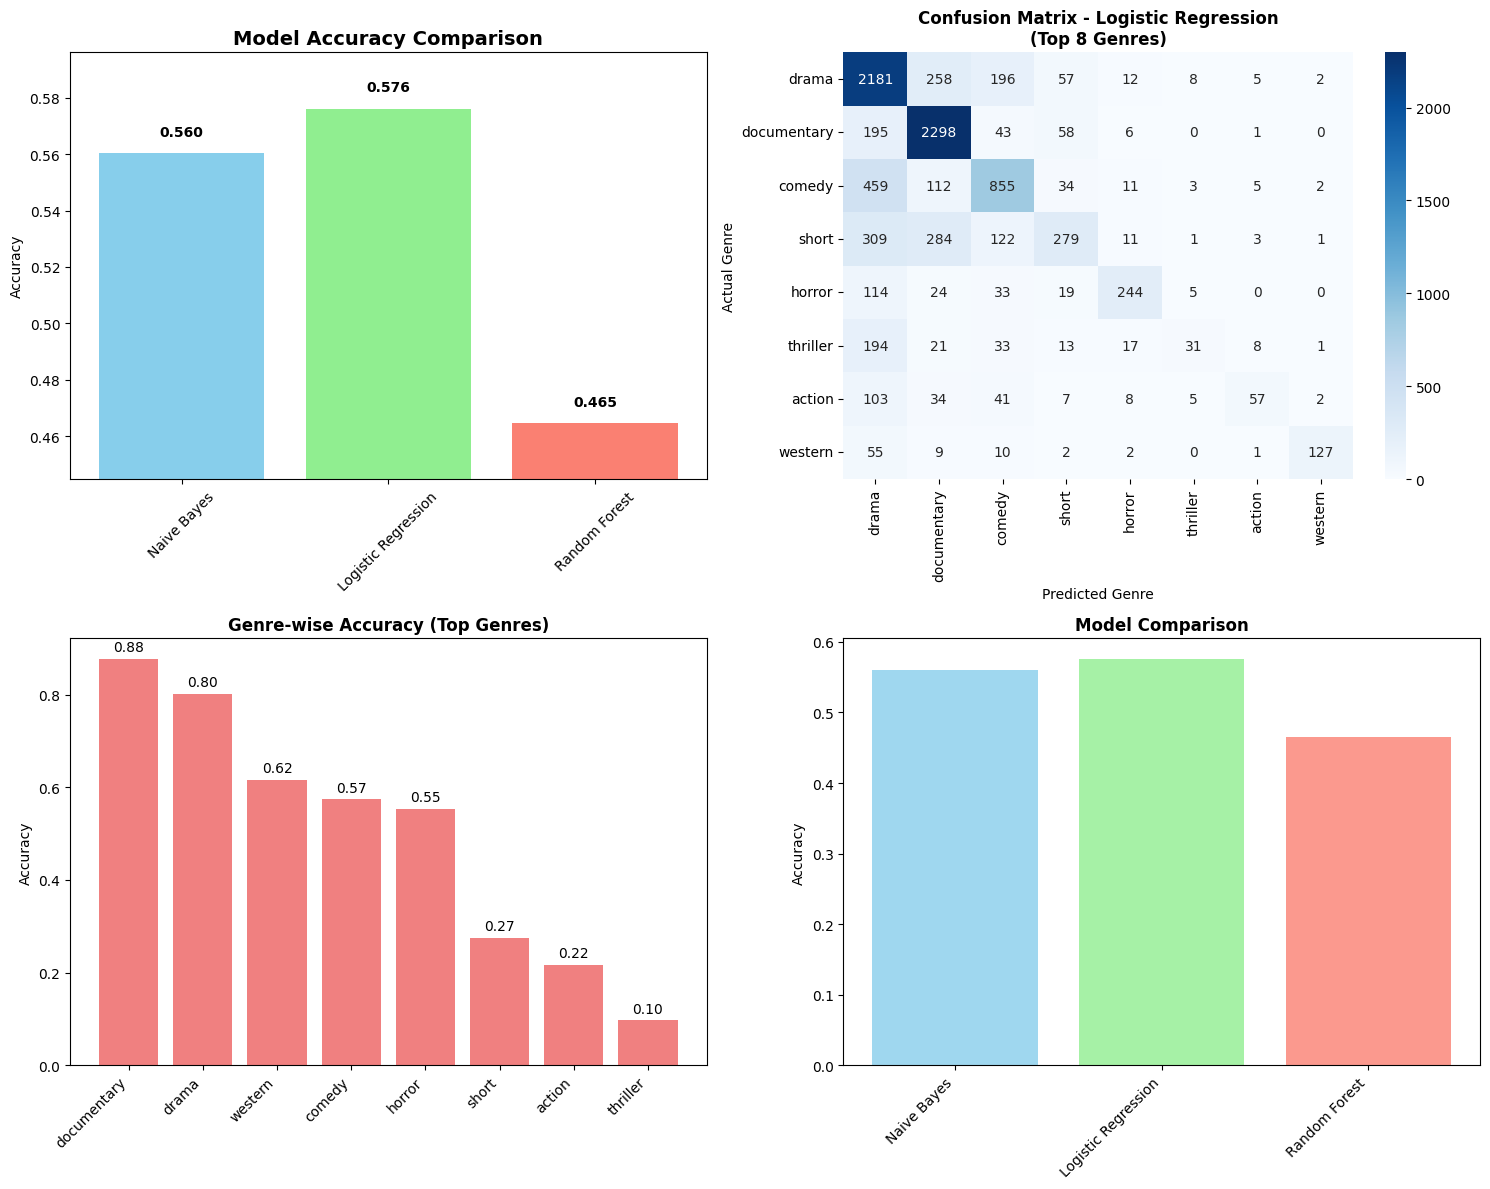


FEATURE IMPORTANCE ANALYSIS 🧐
Most discriminative words for each genre (Logistic Regression):
DRAMA: drama, young, life, lives, relationship, friendship, based, mother, son, tragedy
DOCUMENTARY: documentary, interviews, years, portrait, history, filmmaker, journey, documents, people, intimate
COMEDY: comedy, hilarious, comedic, mockumentary, sitcom, funny, comic, sketches, eccentric, dating
SHORT: short, short film, short documentary, piece, visual, video, poem, bell, experimental, documentary short
HORROR: horror, evil, vampire, blood, house, dead, strange, group, night, woods

MAKING PREDICTIONS ON TEST DATA 📊
Test data loaded into a single column. Splitting...
Test data loaded and processed successfully! ✅
Shape of test data: (54200, 3)
Making predictions on test data using the Logistic Regression model... 
Submission file 'submission.csv' created successfully! 

--- Movie Genre Predictor (Interactive) ---


In [ ]:
# Cell 6: Feature Engineering with TF-IDF (Included for fixing NameError)
"""
TF-IDF (Term Frequency-Inverse Document Frequency) converts text to numerical features
that capture the importance of words in each document relative to the entire corpus.
"""

# Prepare features and target
X = train_data['description_processed']
y = train_data['genre']

print(f"Preparing features for {len(X):,} samples with {y.nunique()} different genres ")

# Split the data before any feature extraction to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples ")
print(f"Test set: {len(X_test):,} samples ")

# Create TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,      # Keep top 15k features
    ngram_range=(1, 2),      # Use both unigrams and bigrams
    min_df=3,               # Ignore terms appearing in less than 3 documents
    max_df=0.85,            # Ignore terms appearing in more than 85% of documents
    stop_words='english',    # Remove English stop words
    lowercase=True,         # Convert to lowercase (though we already did this)
    strip_accents='ascii'   # Remove accents
)

print("Creating TF-IDF features... ")
print("This process extracts important words and phrases from the text... ")

# Fit on training data only to prevent data leakage
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Feature vector dimensions: {X_train_tfidf.shape[1]:,} features")
print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

# Show sample of extracted features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample TF-IDF features:")
print(f"First 20: {list(feature_names[:20])}")
print(f"Random sample: {list(np.random.choice(feature_names, 10))}")


# Cell 7: Model Training - Naive Bayes Classifier
print("\nTraining Multinomial Naive Bayes classifier... ")
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
nb_predictions = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(classification_report(y_test, nb_predictions, target_names=None, zero_division=0))
model_results = {'Naive Bayes': nb_accuracy}

# Cell 8: Model Training - Logistic Regression
print("\nTraining Logistic Regression classifier... ")
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='liblinear',
    random_state=42,
    multi_class='ovr'
)
lr_model.fit(X_train_tfidf, y_train)
lr_predictions = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(classification_report(y_test, lr_predictions, target_names=None, zero_division=0))
model_results['Logistic Regression'] = lr_accuracy

# Cell 10: Model Training - Random Forest
print("\nTraining Random Forest classifier... ")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_tfidf, y_train)
rf_predictions = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions, target_names=None, zero_division=0))
model_results['Random Forest'] = rf_accuracy

# Cell 11: Model Comparison and Visualization
"""
Let's compare all models and visualize their performance to choose the best one.
"""

print("🏆 MODEL PERFORMANCE COMPARISON")
print("=" * 50)

# Sort results by accuracy
sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

for i, (model_name, accuracy) in enumerate(sorted_results):
    medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{medal} {model_name:<20}: {accuracy:.4f} ({accuracy*100:.2f}%)")

best_model_name = sorted_results[0][0]
best_accuracy = sorted_results[0][1]

print(f"\n🎯 Best Model: {best_model_name} with {best_accuracy:.4f} accuracy")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Model comparison bar chart
model_names = list(model_results.keys())
accuracies = list(model_results.values())

bars = axes[0, 0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([min(accuracies) - 0.02, max(accuracies) + 0.02])

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Rotate x-axis labels for better readability
axes[0, 0].tick_params(axis='x', rotation=45)

# Confusion matrix for best model
best_predictions = lr_predictions if best_model_name == 'Logistic Regression' else \
                  nb_predictions if best_model_name == 'Naive Bayes' else rf_predictions

# Show confusion matrix for top genres only (for readability)
top_genres = y_test.value_counts().head(8).index
y_test_top = y_test[y_test.isin(top_genres)]
pred_test_top = pd.Series(best_predictions)[y_test.isin(top_genres).values]

cm = confusion_matrix(y_test_top, pred_test_top, labels=top_genres)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_genres, yticklabels=top_genres, ax=axes[0, 1])
axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}\n(Top 8 Genres)', fontweight='bold')
axes[0, 1].set_xlabel('Predicted Genre')
axes[0, 1].set_ylabel('Actual Genre')

# Genre-wise accuracy analysis
genre_accuracy = {}
for genre in top_genres:
    mask = y_test == genre
    if mask.sum() > 0:  # Only if genre exists in test set
        genre_pred = pd.Series(best_predictions)[mask.values]
        genre_acc = (genre_pred == genre).mean()
        genre_accuracy[genre] = genre_acc

if genre_accuracy:
    genres_sorted = sorted(genre_accuracy.items(), key=lambda x: x[1], reverse=True)
    genre_names, genre_accs = zip(*genres_sorted)

    bars = axes[1, 0].bar(range(len(genre_names)), genre_accs, color='lightcoral')
    axes[1, 0].set_xticks(range(len(genre_names)))
    axes[1, 0].set_xticklabels(genre_names, rotation=45, ha='right')
    axes[1, 0].set_title('Genre-wise Accuracy (Top Genres)', fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy')

    # Add accuracy values on bars
    for bar, acc in zip(bars, genre_accs):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{acc:.2f}', ha='center', va='bottom')

# Model performance comparison
x_pos = np.arange(len(model_names))
axes[1, 1].bar(x_pos, accuracies, capsize=5,
               color=['skyblue', 'lightgreen', 'salmon'], alpha=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].set_title('Model Comparison', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Cell 12: Feature Importance Analysis
print("\nFEATURE IMPORTANCE ANALYSIS 🧐")
feature_names = tfidf_vectorizer.get_feature_names_out()
top_genres_for_analysis = y_train.value_counts().head(5).index
print("Most discriminative words for each genre (Logistic Regression):")
for genre in top_genres_for_analysis:
    try:
        class_idx = list(lr_model.classes_).index(genre)
        coef = lr_model.coef_[class_idx]
        top_positive_idx = coef.argsort()[-10:][::-1] # Reduced to top 10
        top_positive_words = [feature_names[idx] for idx in top_positive_idx]
        print(f"{genre.upper()}: {', '.join(top_positive_words)}")
    except ValueError:
        pass # Genre not in model classes

# Cell 13: Custom Prediction Function
def predict_movie_genre(description, model=lr_model, vectorizer=tfidf_vectorizer, top_n=3):
    processed_desc = clean_text_advanced(description, remove_stopwords=True)
    print(f"Processed description: '{processed_desc}'") # Debug print
    if not processed_desc:
        print("Processed description is empty.") # Debug print
        # Return a default prediction or an indication that prediction was not possible
        return "Unknown", [("Unknown", 0.0)]

    desc_tfidf = vectorizer.transform([processed_desc])
    print(f"TF-IDF vector shape: {desc_tfidf.shape}") # Debug print

    prediction = model.predict(desc_tfidf)[0]
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(desc_tfidf)[0]
        top_indices = probabilities.argsort()[-top_n:][::-1]
        top_predictions = [(model.classes_[idx], probabilities[idx]) for idx in top_indices]
    else:
        top_predictions = [(prediction, 1.0)]

    return prediction, top_predictions

# Cell 14: Model Evaluation on Test Dataset
print("\nMAKING PREDICTIONS ON TEST DATA 📊")
try:
    test_data = pd.read_csv('test_data.txt', sep='\t', header=None)

    # Check if the data was loaded into a single column and split if needed
    if test_data.shape[1] == 1:
        print("Test data loaded into a single column. Splitting...")
        # Assuming the format is ID ::: TITLE ::: DESCRIPTION or ID ::: DESCRIPTION
        # We need to handle both cases. Let's assume it's ID ::: DESCRIPTION for now
        # If it's ID ::: TITLE ::: DESCRIPTION, the split will result in 3 parts
        split_data = test_data[0].str.split(' ::: ', expand=True)

        if split_data.shape[1] == 3:
             test_data[['movie_id', 'title', 'description']] = split_data
        elif split_data.shape[1] == 2:
             test_data[['movie_id', 'description']] = split_data
        else:
            print("Unexpected number of columns after splitting test data.")
            # Attempt to assign the last column as description and the first as movie_id
            test_data['movie_id'] = split_data.iloc[:, 0]
            test_data['description'] = split_data.iloc[:, -1]

        # Drop the original single column
        test_data = test_data.drop(columns=[0])

    # Ensure 'movie_id' and 'description' columns exist
    if 'movie_id' not in test_data.columns or 'description' not in test_data.columns:
         raise ValueError("Could not find 'movie_id' or 'description' columns in test data.")

    print("Test data loaded and processed successfully! ✅")
    print(f"Shape of test data: {test_data.shape}")


    test_data['description_processed'] = test_data['description'].apply(
        lambda x: clean_text_advanced(x, remove_stopwords=True, apply_stemming=False)
    )

    # Handle potential empty descriptions after processing in test data
    initial_test_count = len(test_data)
    test_data = test_data[test_data['description_processed'].str.len() > 0].copy() # Use .copy() to avoid SettingWithCopyWarning
    final_test_count = len(test_data)
    if initial_test_count - final_test_count > 0:
        print(f"Removed {initial_test_count - final_test_count} samples with empty descriptions in test data after preprocessing")
        print(f"Final test dataset size: {final_test_count:,} samples")


    X_test_submission_tfidf = tfidf_vectorizer.transform(test_data['description_processed'])
    print("Making predictions on test data using the Logistic Regression model... ")
    submission_predictions = lr_model.predict(X_test_submission_tfidf)
    submission_df = pd.DataFrame({
        'id': test_data['movie_id'],
        'genre': submission_predictions
    })
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file 'submission.csv' created successfully! ")
except FileNotFoundError:
    print("Error: 'test_data.txt' not found. ❌")
except Exception as e:
    print(f"An error occurred during test data processing or prediction: {e} ")

# Cell 15: Dynamic User Input Prediction
print("\n--- Movie Genre Predictor (Interactive) ---")
while True:
    user_description = input("Enter a movie description (or type 'quit' to exit): ")
    if user_description.lower() == 'quit':
        break
    if user_description:
        prediction, top_predictions = predict_movie_genre(user_description)
        print(f"\nPrimary Prediction: {prediction}")
        print("Top 3 Predictions:")
        for genre, prob in top_predictions:
            print(f"- {genre}: {prob:.3f}")
    else:
        print("Please enter a description.")
    print("-" * 20)

In [12]:
test_descriptions = [
    ("A young farm boy discovers he has magical powers and must save the galaxy from an evil empire with the help of wise mentors and rebel friends.",
     "Expected: Sci-Fi/Fantasy"),

    ("A detective investigates a series of brutal murders in a dark, rain-soaked city while battling his own demons and uncovering police corruption.",
     "Expected: Crime/Thriller"),

    ("Two people from different backgrounds meet by chance and fall deeply in love, but family disapproval and social barriers threaten to keep them apart.",
     "Expected: Romance/Drama"),

    ("Survivors of a zombie apocalypse must navigate through hordes of undead while trying to find a safe haven and maintain their humanity.",
     "Expected: Horror/Action"),

    ("A group of friends embark on a hilarious road trip filled with mishaps, misunderstandings, and laugh-out-loud moments as they try to reach their destination.",
     "Expected: Comedy"),

    ("In medieval times, a brave knight must rescue a princess from a dragon while facing various challenges and discovering the true meaning of courage.",
     "Expected: Fantasy/Adventure")
]

print("--- Testing with Provided Examples ---")
for description, expected in test_descriptions:
    print(f"\nDescription: {description}")
    print(f"Expected: {expected}")
    prediction, top_predictions = predict_movie_genre(description)
    print(f"Primary Prediction: {prediction}")
    print("Top 3 Predictions:")
    for genre, prob in top_predictions:
        print(f"- {genre}: {prob:.3f}")
    print("-" * 30)

--- Testing with Provided Examples ---

Description: A young farm boy discovers he has magical powers and must save the galaxy from an evil empire with the help of wise mentors and rebel friends.
Expected: Expected: Sci-Fi/Fantasy
Processed description: 'young farm boy discovers magical powers must save galaxy evil empire help wise mentors rebel friends'
TF-IDF vector shape: (1, 15000)
Primary Prediction: animation
Top 3 Predictions:
- animation: 0.362
- horror: 0.116
- drama: 0.088
------------------------------

Description: A detective investigates a series of brutal murders in a dark, rain-soaked city while battling his own demons and uncovering police corruption.
Expected: Expected: Crime/Thriller
Processed description: 'detective investigates series brutal murders dark rain soaked city battling demons uncovering police corruption'
TF-IDF vector shape: (1, 15000)
Primary Prediction: thriller
Top 3 Predictions:
- thriller: 0.222
- horror: 0.192
- drama: 0.109
----------------------